In [1]:
from bootstrapSetup import *
from IPython.display import display, clear_output
from datetime import datetime

dataset generated as 'loader
embedder created as transformer
Embedded shape: torch.Size([4, 128])
Using device: cuda


In [7]:
EXPERIMENT_NAME= "HighInference_SquareLess2"

# Improvements
* Check connectivity through connection map
* Check edgecase of wireset

In [3]:
def checkConnectivity(connectionMap, socketMap):
    curIndex = 0
    connections = []
    exhaustedSockets = set()

    def exhaustSocketSource(socket):
        if any(not s.isSource for c in socketMap[socket] for s in connectionMap[c]): # if socket transmits to anything
            exhaustedSockets.add(socket)

        for c in socketMap[socket]:
            if c not in connections:
                connections.append(c)

    for inp, pos in inpSockets:
        exhaustSocketSource(inp)
    
    while curIndex < len(connections):
        c = connections[curIndex]
        for s in connectionMap[c]:
            if not s.isSource:
                exhaustedSockets.add(s)

            prefix, idnum, comptype = s.name

            if comptype:
                if (f"{prefix}{idnum}base" in exhaustedSockets and 
                    f"{prefix}{idnum}collector" in exhaustedSockets):
                    if f"{prefix}{idnum}emitter" not in connections and socketMap[f"{prefix}{idnum}emitter"]:
                        if any(not s.isSource for c in socketMap[f"{prefix}{idnum}emitter"] for s in connectionMap[c]):
                            exhaustSocketSource(f"{prefix}{idnum}emitter")

        curIndex += 1
    return connections, exhaustedSockets

def prePruningv2(socketMap, exhaustedSockets):
    connectedInps = []
    connectedOuts = []

    notConnectedGateIDs = []
    for s in socketMap:
        connected = s in exhaustedSockets
        prefix, idnum, comptype = s.name

        if comptype:
            if not connected and int(idnum) not in notConnectedGateIDs:
                notConnectedGateIDs.append(int(idnum))
        else:
            if connected:
                if prefix == "inp":
                    connectedInps.append(int(idnum))
                else: 
                    connectedOuts.append(int(idnum))


    return connectedInps, connectedOuts, notConnectedGateIDs

def gateRemoval(circuit, gatesToClean):
    if len(gatesToClean) == 0:
        return circuit
    
    gateToCleanIndex = 0
    curGate = 0
    for i in range(circuit.shape[0]):
        for j in range(circuit.shape[1]):
            if circuit[i][j] > 1:
                if gatesToClean[gateToCleanIndex] == curGate:
                    circuit[i][j] = 1
                    gateToCleanIndex += 1
                    if gateToCleanIndex >= len(gatesToClean):
                        return circuit

                curGate += 1
    
    return circuit


def afterPruningv2(circuit, wiresets, connectedSets):
    circuitWasUpdated = False
    for i in range(circuit.shape[0]):
        for j in range(circuit.shape[1]):
            if wiresets[i][j] not in connectedSets and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitWasUpdated = True

    return circuit, circuitWasUpdated

In [4]:
# Training Function
def trainCatModel(catModel, dataloader, embeddingModel, losses, stopAccuracy = 0.05, batchLimit = 100, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')

    if PLOTUPDATES:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    opt = torch.optim.Adam(catModel.parameters(), lr=1e-4) 


    batchNum = 0
    isTraining = True
    while isTraining:
        for batch, labels in dataloader:

            timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

            noisyImgs = scheduler.addNoise(batch, timesteps)

            embeddings = embeddingModel(labels)

            pred = catModel(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))

            loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

            if PLOTUPDATES:
                if len(losses) % updateRate == 0:
                    clear_output(wait=True)  
                    ax.clear()
                    plt.plot(losses)
                    plt.xlabel('Batch')
                    display(fig)
                    
            batchNum += 1
            if loss < stopAccuracy:
                    isTraining = False
                    break
            elif batchNum >= batchLimit:
                isTraining = False
                break
    
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses

# Prunes excess wires from the circuit.
def CrossValue(circuit, i, j):
    up     = circuit[i - 1][j] if i > 0 else 0
    center = circuit[i][j]
    down   = circuit[i + 1][j] if i < circuit.shape[0] - 1 else 0
    left   = circuit[i][j - 1] if j > 0 else 0
    right  = circuit[i][j + 1] if j < circuit.shape[1] - 1 else 0

    return center + up + down + left + right


# Prunes excess wires from the circuit.
def pruneExcessWires(circuit):
    circuitDirty = False
    
    for j in range(1, circuit.shape[0] - 1):
        for i in range(circuit.shape[1]):
            crossValue = CrossValue(circuit, i, j)

            if crossValue < 3 and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitDirty = True


    #For end columns, allow wires connected to sockets
    for j in [0, circuit.shape[0] - 1]:
        for i in range(circuit.shape[0]):
            crossValue = CrossValue(circuit, i, j)

            if not i % 4 == 0 and crossValue < 3 and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitDirty = True
            elif i % 4 == 0 and crossValue < 2 and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitDirty = True              
    
    if circuitDirty:
        return pruneExcessWires(circuit)
    else: return circuit, circuitDirty

def requireGate(circuit):
    rows = circuit.shape[0]
    cols = circuit.shape[1]

    for i in range(rows):
        for j in range(cols):
            if circuit[i][j] > 1:
                return True
    return False

In [5]:
def generateSocketCombinations(inputSockets, relevantIndexes):
    #inputSockets = All available input sockets
    #relevantIndexes = the indexes of sockets that are connected to components
    
    usedSockets = [inputSockets[i][0] for i in relevantIndexes]
    
    # Generate all combinations (power set)
    orderList = []
    for r in range(len(usedSockets) + 1):
        for combo in combinations(usedSockets, r):
            orderList.append(list(combo))
    
    return orderList


In [6]:
# Generate N Circuits
def GenerateN(model, amount = 100):
    model.eval()
    
    ## GENERATE CIRCUITS
    with torch.no_grad():
        batchX = torch.randint(size=(amount, 13, 13), high = 4, low = 0, device=device )
        batchX = imageToProbabilities(batchX, 4)

        batchY = torch.randint(size=(amount, 16, 8), high = 3, low = 0, device='cpu' )
        batchY = transformer(batchY).to(device)
        
        # Inference with trainingsteps // 64 + 1, for faster generations. Even with this few steps, generations become perfect after training, due to small dataset.
        stepDivisor = 16
        inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps // stepDivisor, device='cpu').long()

        
        for t in inferenceSteps:
            residual_cond = model(batchX.to(device).float(), t, batchY.float()) 
            residual = F.softmax(residual_cond, dim=1)
            batchX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
        batchX = F.softmax(model(batchX.to(device), 0, batchY), dim=1)

        # Get circuit values
        argmaxedBatch = torch.argmax(batchX, dim=1, keepdim=True).cpu().numpy().squeeze()

        return argmaxedBatch
    

In [8]:
def hasWireSquare(circuit):
    #Just disallow these.
    rows = circuit.shape[0]
    cols = circuit.shape[1]

    for i in range(rows - 1):
        for j in range(cols - 1):
            if (circuit[i][j] >= 1 and
                circuit[i][j + 1] >= 1 and
                circuit[i + 1][j] >= 1 and
                circuit[i + 1][j + 1] >= 1):
                return True
    return False


def getTables(circuits):
    #Prunes
    #Checks hashes
    #Simulates
    #Then, generates tables
    with torch.no_grad():
        tables = []
        simulatedCircuits = []
        simulatedCircuitHashes = []

        unique_hashes = {}
        circuitsErrors = defaultdict(int)
        for i in range((circuits.shape[0])):
            circuitDirty = True # Pruning flag

            circuit = circuits[i]
            while circuitDirty:
                socketMap, wireSets = GetSocketMap(circuit, inpSockets + outSockets)
                connectionMap = GetConnectionMap(socketMap)

                connectedSets, exhaustedSockets = checkConnectivity(connectionMap, socketMap)
                inps, outs, notConnectedGateIDs = prePruningv2(socketMap, exhaustedSockets)
                circuit = gateRemoval(circuit, notConnectedGateIDs)

                socketMap, wireSets = GetSocketMap(circuit, inpSockets + outSockets)
                connectionMap = GetConnectionMap(socketMap)
                connectedSets, exhaustedSockets = checkConnectivity(connectionMap, socketMap)
                circuit, changed1 = afterPruningv2(circuit, wireSets, connectedSets)
                circuit, changed2 = pruneExcessWires(circuit)                
                circuitDirty = changed1 or changed2

            if hasWireSquare(circuit):
                circuitsErrors["Has Square"] += 1
                continue
                            
            hash = get_tensor_hash(circuit)
            if hash not in unique_hashes:
                if hash not in dataset.hashes:

                    #Get orderlist
                    if len(inps) > 1 and len(outs) > 0: # Bias to have only circuits with at least 2 inputs
                        orderlist = generateSocketCombinations(inpSockets, inps)

                        try:    
                            if requireGate(circuit):
                                truthTable = GetTruthTable(inps, outs, socketMap, connectionMap, orderlist)
                                tables.append(truthTable)
                                simulatedCircuits.append(circuit)
                                simulatedCircuitHashes.append(hash)
                                unique_hashes[hash] = i
                            else:
                                circuitsErrors["No gates"] += 1        

                        except Exception as e:
                            circuitsErrors[str(e)] += 1
                    else:
                        circuitsErrors["Not Sufficiently Connected"] += 1
                else:
                    circuitsErrors["Duplicate"] += 1
            else:
                circuitsErrors["New Duplicate"] += 1
                
        return tables, simulatedCircuits, simulatedCircuitHashes, circuitsErrors

In [9]:

# GenerateN and getTables combined.
def GenerateAndSimulate(model, amount = 100): 
    argmaxCircuits = GenerateN(model, amount)
    tables, simulatedCircuits, simulatedCircuitsHashes, errors = getTables(argmaxCircuits)

    return tables, simulatedCircuits, simulatedCircuitsHashes, errors


def SampleCircuits(model, iterations = 10, samples = 512):
    newCircuits = []
    newCircuitHashes = []
    newTables = []

    errors = defaultdict(int)
    for i in range(iterations):
        t, a, h, e = GenerateAndSimulate(model, amount=samples)
        for circuit, hash, table in zip(a, h, t):
            if hash not in newCircuitHashes:
                newCircuitHashes.append(hash)   
                newCircuits.append(circuit)
                newTables.append(table)

        for error, count in e.items():
            errors[error] += count

    return newCircuits, newTables, errors


def save_progress(model, circuitErrors, trainingDict, trainingDictSize, dataIncrease, amountShorter, amountCircuitsGenerated):
    # Get today's date in YYYY-MM-DD format
    today_str = datetime.now().strftime('%Y-%m-%d')
    
    # Construct the result directory path
    result_dir = os.path.join('output', today_str)
    os.makedirs(result_dir, exist_ok=True)

    # Define filenames with 'experiment_' prefix, no date
    model_filename = f'{EXPERIMENT_NAME}_model.pt'
    data_filename = f'{EXPERIMENT_NAME}_training_data.pkl'

    # Save model
    torch.save(model.state_dict(), os.path.join(result_dir, model_filename))

    # Save other data
    save_data = {
        'circuitErrors': circuitErrors,
        'trainingDict': trainingDict,
        'trainingDictSize': trainingDictSize,
        'dataIncrease': dataIncrease,
        'amountCircuitsGenerated': amountCircuitsGenerated,
        'amountShorter': amountShorter
    }

    with open(os.path.join(result_dir, data_filename), 'wb') as f:
        pickle.dump(save_data, f)

In [10]:
def plot_25(item): # Returns the fig instead of displaying it
    cmap = ListedColormap(['white', 'black', 'red', 'blue'])
    cols = 5
    rows = min(len(item) + 4, 25) // cols
    if rows == 0:
        return

    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))

    for idx, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx >= len(item):
            continue
        ax.imshow(item[idx], cmap=cmap, vmin=0, vmax=3)
    plt.tight_layout()
    return fig


def Bootstrap(epochs, model, loss, trainingDict): #Make error dict?
    dataset = CircuitDataset(trainingDict)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    errorClasses = ["Has Square", "No gates", "Not Sufficiently Connected", "Duplicate", "New Duplicate"]
    circuitErrors = {error: [] for error in errorClasses}

    trainingDictSize = [len(trainingDict)]
    dataIncrease = []
    amountCircuitsGenerated = []
    amountShorter = []

    for epoch in tqdm(range(epochs)):
        #Train model
        model, loss = trainCatModel(model, loader, transformer, loss, PLOTUPDATES=False)

        # Generate new data
        newCircuits, newTables, errors = SampleCircuits(model, samples=256)
        for error in errorClasses:
            circuitErrors[error].append(errors[error])
        amountCircuitsGenerated.append(len(newCircuits))
            
        # Update training dictionary
        pastLen = len(trainingDict)
        trainingDict, fasterCircuits = CreateTrainingDictionary(trainingDict, torch.tensor(newCircuits), newTables)
        dataset = CircuitDataset(trainingDict)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)
        dataIncrease.append(len(trainingDict) - pastLen)
        trainingDictSize.append(len(trainingDict))
        amountShorter.append(fasterCircuits)

        # Save progress
        save_progress(model, circuitErrors, trainingDict, trainingDictSize, dataIncrease, amountShorter, amountCircuitsGenerated)


        # Draw updates
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 3, figsize=(15, 4)) 

        axes[0].plot(trainingDictSize)
        axes[0].set_title('Size of trainingDict')

        for label, values in circuitErrors.items():
            axes[1].plot(values, label=label)
        axes[1].plot(dataIncrease, label="Samples added to training data")
        axes[1].plot(amountCircuitsGenerated, label="Succesful Samples")
        axes[1].plot(amountShorter, label="Shorter Samples")
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Circuit errors over time')
        axes[1].legend()

        axes[2].plot(loss)
        axes[2].set_xlabel('Batch')
        axes[2].set_title('Loss') # This should add lines or something to show whenever retraining happens

        fig2 = plot_25(newCircuits)

        display(fig)
        plt.close(fig)
        display(fig2)
        plt.close(fig2)

    return model, loss, trainingDict

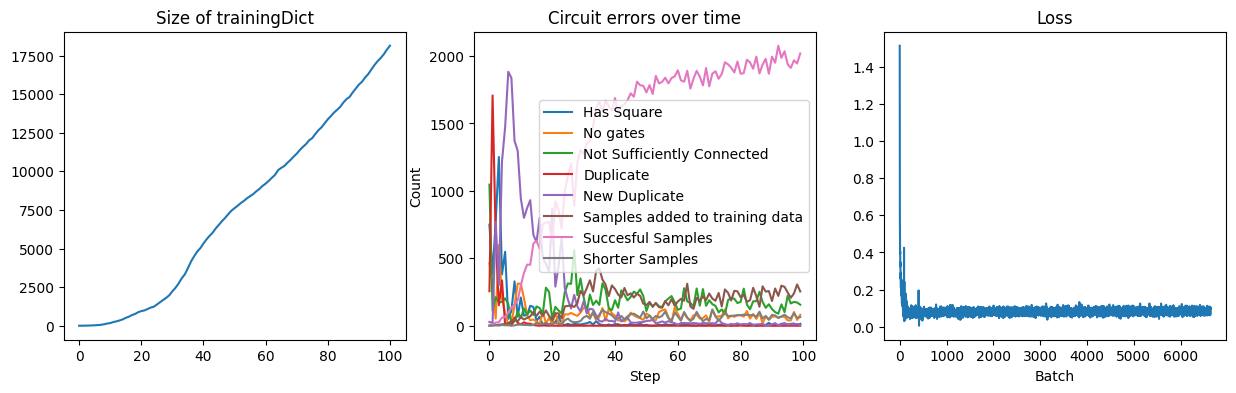

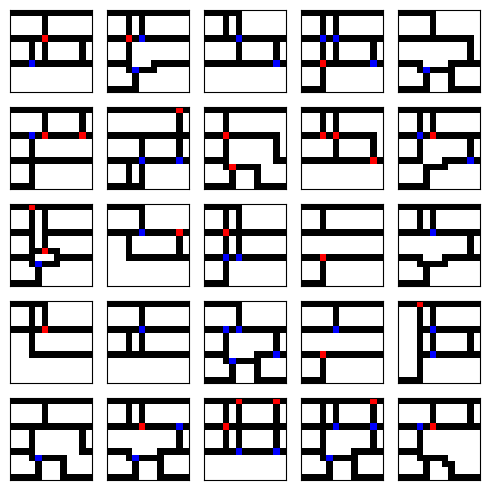

100%|██████████| 100/100 [1:27:15<00:00, 52.35s/it]


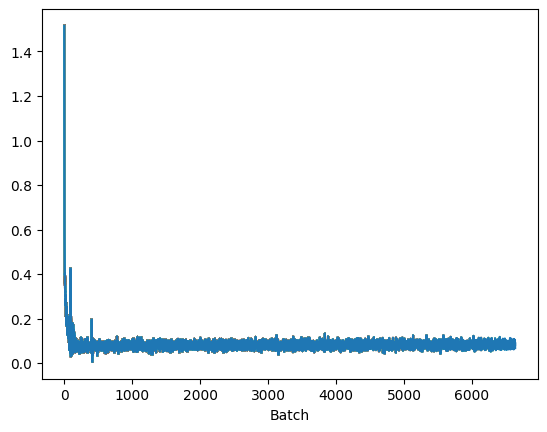

In [11]:
trainingDict, _ = CreateTrainingDictionary({}, InitialCicuits, InitialTables)
dataset = LoopingDataset(trainingDict)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = CategoricalDiffusionModel(13, 4, 128).to(device)
model, loss = trainCatModel(model, loader, transformer, [], PLOTUPDATES=False)
model, loss, trainingDict = Bootstrap(100, model, loss, trainingDict)